# Install the dependency for data collection

In [1]:
!pip install yfinance ta

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 29.6 MB/s 
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=7e2b1a333428083d1760ba31cd06523e67ae754f4687c6f5d77624e64174d79b
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium=

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from keras.models import Sequential
from keras.layers import Conv1D,MaxPool1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from ta.trend import IchimokuIndicator
from sklearn.linear_model import LinearRegression
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sn

# Data Pre-processing

In [3]:
symbol = '2800.HK'#'0001.HK'
stock = yf.Ticker(symbol)
#df = stock.history(period="max")
df = stock.history(start="2008-01-01", end="2020-12-31")
stock_data = df[['Open',  'High',  'Low',  'Close', 'Volume']]

df_test = stock.history(start="2020-12-31", end="2022-12-31")
stock_data_test = df_test[['Open',  'High',  'Low',  'Close', 'Volume']]

In [4]:
def generate_ds(ds):
  indicator_bollinger = BollingerBands(close=ds["Close"], window=20, window_dev=2)
  macd = MACD(close=ds["Close"])
  rsi = RSIIndicator(close=ds["Close"])
  ichi = IchimokuIndicator(high=ds["High"],low=ds["Low"])

  #get the technical indicators
  ds['macd'] = macd.macd()
  ds['macd_signal'] = macd.macd_signal()
  ds['rsi'] = rsi.rsi()
  ds['bollinger_mavg'] = indicator_bollinger.bollinger_mavg()
  ds['bollinger_hband'] = indicator_bollinger.bollinger_hband()
  ds['bollinger_lbond'] = indicator_bollinger.bollinger_lband()
  ds['ichimoku_a'] = ichi.ichimoku_a()
  ds['ichimoku_b'] = ichi.ichimoku_b()
  ds['ichimoku_base_line'] = ichi.ichimoku_base_line()
  ds['ichimoku_conversion_line'] = ichi.ichimoku_conversion_line()
  ds = ds.fillna(0)
  return ds

In [5]:
stock_data = generate_ds(stock_data)
stock_orig = stock_data.copy()

stock_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line
Date,,,,,,,,,,,,,,,
2008-01-02,27.730000,27.730000,27.730000,27.730000,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.730000,0.00,0.00
2008-01-03,27.059999,27.059999,27.059999,27.059999,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395000,0.00,0.00
2008-01-04,27.690001,27.690001,27.690001,27.690001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395000,0.00,0.00
2008-01-07,27.350000,27.350000,27.350000,27.350000,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395000,0.00,0.00
2008-01-08,27.280001,27.280001,27.280001,27.280001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,27.395000,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,26.260000,26.520000,26.240000,26.520000,54078882,0.067978,0.138404,50.723303,26.666,27.061596,26.270404,26.605,25.679999,26.69,26.52
2020-12-24,26.600000,26.600000,26.600000,26.600000,0,0.065829,0.123889,52.326054,26.649,27.024761,26.273239,26.600,25.679999,26.69,26.51
2020-12-28,26.580000,26.700001,26.459999,26.480000,96582169,0.053823,0.109876,49.713999,26.619,26.944816,26.293184,26.600,25.679999,26.69,26.51


In [6]:
stock_data_test = generate_ds(stock_data_test)
stock_test_orig = stock_data_test.copy()

stock_data_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Volume,macd,macd_signal,rsi,bollinger_mavg,bollinger_hband,bollinger_lbond,ichimoku_a,ichimoku_b,ichimoku_base_line,ichimoku_conversion_line
Date,,,,,,,,,,,,,,,
2020-12-31,27.440001,27.440001,27.440001,27.440001,0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.440001,0.000000,0.000000
2021-01-04,27.360001,27.680000,27.320000,27.639999,228402605,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.500000,0.000000,0.000000
2021-01-05,27.480000,27.879999,27.340000,27.740000,139782911,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.599999,0.000000,0.000000
2021-01-06,27.799999,27.940001,27.580000,27.840000,145424037,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.630000,0.000000,0.000000
2021-01-07,27.840000,27.920000,27.620001,27.700001,134972086,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,27.630000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07,21.500000,21.500000,20.959999,21.219999,217260223,-0.619358,-0.340605,22.628970,23.739,25.965440,21.512559,22.739999,23.059999,23.059999,22.419999
2022-03-08,21.280001,21.440001,20.760000,20.879999,262888986,-0.730871,-0.418658,20.918539,23.559,26.079396,21.038603,22.545000,22.960000,22.960000,22.130000
2022-03-09,21.000000,21.120001,20.240000,20.780001,385661835,-0.817887,-0.498504,20.429440,23.350,26.057338,20.642661,22.205000,22.700000,22.700000,21.710000


# Min-Max Normalization

In [7]:
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,0:3])
stock_data.iloc[:,0:3] = scaled_values

y_scaler = preprocessing.MinMaxScaler()
scaled_values = y_scaler.fit_transform(np.array(stock_data.iloc[:,3]).reshape(-1,1))
stock_data.iloc[:,3] = scaled_values

scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(stock_data.iloc[:,4:])
stock_data.iloc[:,4:] = scaled_values

In [8]:
scaler_test = preprocessing.MinMaxScaler()
scaled_values = scaler_test.fit_transform(stock_data_test.iloc[:,0:3])
stock_data_test.iloc[:,0:3] = scaled_values

y_scaler_test = preprocessing.MinMaxScaler()
scaled_values = y_scaler_test.fit_transform(np.array(stock_data_test.iloc[:,3]).reshape(-1,1))
stock_data_test.iloc[:,3] = scaled_values

scaler_test = preprocessing.MinMaxScaler()
scaled_values = scaler_test.fit_transform(stock_data_test.iloc[:,4:])
stock_data_test.iloc[:,4:] = scaled_values

# Data Analysis

In [9]:
L_stock = stock_data.drop(['Close'],1)[:-1]
L_stock['next_close'] = stock_data['Close'].shift(-1)[:-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


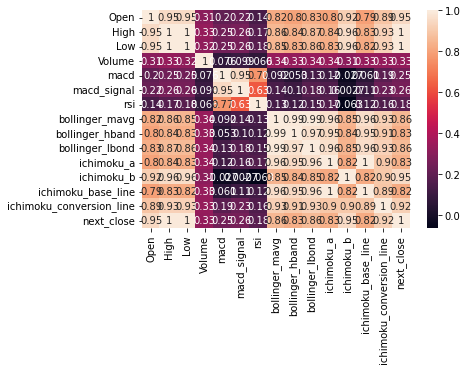

In [10]:
corrMatrix = L_stock.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


Feature: 0 - Open, Score: -0.01236
Feature: 1 - High, Score: 0.58268
Feature: 2 - Low, Score: 0.36293
Feature: 3 - Volume, Score: 0.00250
Feature: 4 - macd, Score: -0.04212
Feature: 5 - macd_signal, Score: 0.04121
Feature: 6 - rsi, Score: 0.03755
Feature: 7 - bollinger_mavg, Score: -0.00147
Feature: 8 - bollinger_hband, Score: -0.01280
Feature: 9 - bollinger_lbond, Score: 0.01118
Feature: 10 - ichimoku_a, Score: -0.08295
Feature: 11 - ichimoku_b, Score: 0.06366
Feature: 12 - ichimoku_base_line, Score: 0.08318
Feature: 13 - ichimoku_conversion_line, Score: -0.01639


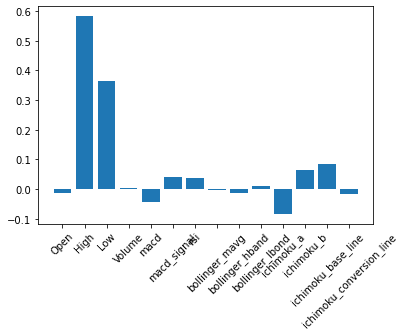

In [11]:
L_stock = stock_data.drop(['Close'],1)[:-1]
tmr_close = stock_data['Close'].shift(-1)[:-1]	#tomorrow close price
model = LinearRegression()
model.fit(L_stock.iloc[:,:], tmr_close.iloc[:,])
#model.fit(L_stock, stock_data['Close'])
importance = model.coef_
for i,v in enumerate(importance):
	print('Feature: %0d - %s, Score: %.5f' % (i,L_stock.columns[i],v))
plt.bar([L_stock.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=45)
plt.show()

#original dataset split

In [12]:
def gen_data_pair(dataset, fin_ds, features=11, window_size = 60):
  X = []
  Y = []
  for i in range(0 , len(dataset) - window_size , 1):
    X.append(np.array(fin_ds.iloc[i:i+window_size,:]).reshape(window_size * features,1))
    Y.append(np.array(dataset.iloc[i+window_size,3]).reshape(1,1))
  tr_X = np.array(X)
  tr_label = np.array(Y)
  tr_X = tr_X.reshape(tr_X.shape[0],features,window_size,1)
  return tr_X,tr_label


In [13]:
window_size = 60  #the length of the sequence

#for training data
stock_final = stock_data.drop(['Open','Volume','bollinger_mavg','ichimoku_conversion_line'],1)
train_X, train_label = gen_data_pair(stock_data, stock_final)

#for validation data
stock_final_test = stock_data_test.drop(['Open','Volume','bollinger_mavg','ichimoku_conversion_line'],1)
test_X, test_label = gen_data_pair(stock_final_test, stock_final_test)

print("number of training data: ", len(train_label))
print('number of tseting data: ', len(test_label))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


number of training data:  3147
number of tseting data:  235


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


# Model Training

In [14]:
model = Sequential()
#add model layers
model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu', input_shape=(None,window_size,1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(384, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(768, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.fit(train_X, train_label, validation_data=(test_X,test_label), epochs=450)
print(model.summary())
print(model.evaluate(test_X,test_label))

Epoch 1/450
99/99 [==============================] - 44s 94ms/step - loss: 0.0221 - val_loss: 0.0907
Epoch 2/450
99/99 [==============================] - 7s 71ms/step - loss: 0.0045 - val_loss: 0.0602
Epoch 3/450
99/99 [==============================] - 7s 71ms/step - loss: 0.0036 - val_loss: 0.0814
Epoch 4/450
99/99 [==============================] - 7s 71ms/step - loss: 0.0030 - val_loss: 0.0567
Epoch 5/450
99/99 [==============================] - 7s 71ms/step - loss: 0.0027 - val_loss: 0.0590
Epoch 6/450
99/99 [==============================] - 7s 74ms/step - loss: 0.0026 - val_loss: 0.0498
Epoch 7/450
99/99 [==============================] - 7s 75ms/step - loss: 0.0023 - val_loss: 0.0719
Epoch 8/450
99/99 [==============================] - 7s 71ms/step - loss: 0.0021 - val_loss: 0.0567
Epoch 9/450
99/99 [==============================] - 7s 71ms/step - loss: 0.0021 - val_loss: 0.0287
Epoch 10/450
99/99 [==============================] - 7s 71ms/step - loss: 0.0026 - val_loss: 0.066

# Model Evaluation

In [15]:
window_size = 60
features = 11

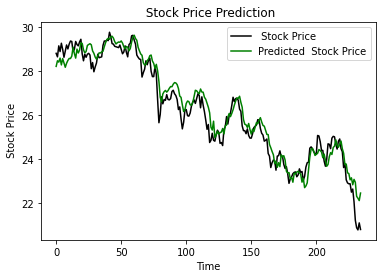

8/8 [==============================] - 0s 24ms/step - loss: 0.0491


0.049130380153656006

In [16]:
predicted  = model.predict(test_X)

#real_price = y_scaler.inverse_transform(test_label[:,0])
real_price = stock_test_orig.iloc[window_size:,3].values
predicted = np.array(predicted[:,0]).reshape(-1,1)
predicted = y_scaler_test.inverse_transform(predicted)
plt.plot(real_price, color = 'black', label = ' Stock Price')
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

model.evaluate(test_X,test_label)

# Make the price prediction for next day

In [17]:
x_pred = []
x_pred.append(np.array(stock_final_test.iloc[-window_size:,:]).reshape(window_size * features,1))
x_pred = np.array(x_pred)
x_pred = x_pred.reshape(x_pred.shape[0],features,window_size,1)
next_price  = model.predict(x_pred)
next_price = np.array(next_price[:,0]).reshape(-1,1)
next_price = y_scaler_test.inverse_transform(next_price)
next_price[0][0]

22.17948

# Save the Model

In [18]:
model.save('lstm-cnn-20220312.h5')

In [20]:
from google.colab import files
files.download('lstm-cnn-20220312.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>